In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


# Import Libraries

In [2]:
import os
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import re

# Define Helper Functions

In [3]:
def get_class_from_filename(filename):
    """
    Extrait le nom de la classe à partir du nom du fichier.
    Exemples :
    - "apple001T(2)" → "apple"
    - "apple001S(2)_aug_6" → "apple"
    """
    # Utiliser une expression régulière pour extraire la partie alphabétique au début du nom
    match = re.match(r"^[a-zA-Z]+", filename)
    if match:
        return match.group(0).lower()  # Convertir en minuscules pour uniformité
    else:
        raise ValueError(f"Impossible d'extraire la classe du fichier : {filename}")

def load_image(image_path, target_size=(224, 224)):
    """
    Charge et prétraite une seule image.
    """
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, target_size)
    img = img / 255.0  # Normalisation entre [0, 1]
    return img

def create_dataset(image_paths, labels, target_size=(224, 224), batch_size=32, shuffle=True):
    """
    Crée un dataset TensorFlow à partir des chemins d'images et des labels.
    """
    # Convertir les chemins d'images et les labels en tenseurs TensorFlow
    image_paths = tf.constant(image_paths)
    labels = tf.constant(labels)

    # Créer un dataset à partir des chemins d'images
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    # Charger et prétraiter les images
    dataset = dataset.map(lambda x, y: (load_image(x, target_size), y), num_parallel_calls=tf.data.AUTOTUNE)

    # Mélanger et regrouper le dataset
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

def get_image_paths_and_labels(folder_path, max_images_per_class=None):
    """
    Récupère les chemins d'images et les labels d'un dossier.
    Si max_images_per_class est spécifié, ne charge que ce nombre d'images par classe.
    """
    image_paths = []
    labels = []
    class_counts = {}

    files = os.listdir(folder_path)
    for img_file in files:
        if img_file.lower().endswith('.jpg'):
            # Extraire le label à partir du nom du fichier
            label = get_class_from_filename(img_file)

            # Vérifier si la limite pour cette classe est atteinte
            if max_images_per_class is not None:
                if label in class_counts and class_counts[label] >= max_images_per_class:
                    continue  # Ignorer cette image si la limite est atteinte

            image_paths.append(os.path.join(folder_path, img_file))
            labels.append(label)

            # Mettre à jour le compteur pour cette classe
            if label in class_counts:
                class_counts[label] += 1
            else:
                class_counts[label] = 1

    return image_paths, labels

# Load and Prepare Data

In [4]:
# Chemins des dossiers
base_path = '/kaggle/input/ecustfd-resized-augmented/food_dataset'
original_images_path = os.path.join(base_path, 'original_images')
augmented_images_path = os.path.join(base_path, 'augmented_images')

# Récupérer les chemins d'images et les labels pour les images originales
original_image_paths, original_labels = get_image_paths_and_labels(original_images_path)

# Récupérer les chemins d'images et les labels pour les images augmentées (500 images par classe)
augmented_image_paths, augmented_labels = get_image_paths_and_labels(augmented_images_path, max_images_per_class=1000)

# Combiner les données originales et augmentées
train_image_paths = original_image_paths + augmented_image_paths
train_labels = original_labels + augmented_labels

# Encoder les labels
label_encoder = LabelEncoder()
label_encoder.fit(train_labels)
train_labels_encoded = label_encoder.transform(train_labels)

# Convertir les labels en one-hot encoding
num_classes = len(label_encoder.classes_)
train_labels_onehot = to_categorical(train_labels_encoded, num_classes=num_classes)

# Diviser les données en ensembles d'entraînement et de validation
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_image_paths, train_labels_onehot, test_size=0.2, random_state=42, stratify=train_labels_encoded
)

# Créer les datasets TensorFlow
train_dataset = create_dataset(train_paths, train_labels, batch_size=32, shuffle=True)
val_dataset = create_dataset(val_paths, val_labels, batch_size=32, shuffle=False)

# Define and Compile the Model

In [5]:
def create_improved_food_classifier(input_shape=(224, 224, 3), num_classes=20):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Initial feature extraction
    x = tf.keras.layers.Conv2D(64, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4), kernel_initializer='he_normal')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(2, strides=2)(x)
    x = tf.keras.layers.Dropout(0.2)(x)  # Ajout de dropout

    # First block with residual connection
    skip = x
    x = tf.keras.layers.Conv2D(64, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4), kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(64, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4), kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Add()([x, skip])
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(2, strides=2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)  # Ajout de dropout

    # Second block
    x = tf.keras.layers.Conv2D(128, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4), kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)  # Augmentation du dropout
    x = tf.keras.layers.MaxPooling2D(2, strides=2)(x)

    # Third block with squeeze-excitation
    x = tf.keras.layers.Conv2D(256, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4), kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Squeeze-Excitation block
    se = tf.keras.layers.GlobalAveragePooling2D()(x)
    se = tf.keras.layers.Dense(256 // 16, activation='relu', kernel_initializer='he_normal')(se)
    se = tf.keras.layers.Dense(256, activation='sigmoid', kernel_initializer='he_normal')(se)
    se = tf.keras.layers.Reshape((1, 1, 256))(se)
    x = tf.keras.layers.Multiply()([x, se])

    x = tf.keras.layers.MaxPooling2D(2, strides=2)(x)
    x = tf.keras.layers.Dropout(0.5)(x)  # Augmentation du dropout

    # Global features
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Dense layers
    x = tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(1e-4), kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.6)(x)  # Augmentation du dropout

    x = tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(1e-4), kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.6)(x)  # Augmentation du dropout

    # Output layer
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax', kernel_initializer='he_normal')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# Create and compile the model
model = create_improved_food_classifier(input_shape=(224, 224, 3), num_classes=20)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy'), tf.keras.metrics.AUC(name='auc')])

# Train the Model

In [6]:
# Définir les callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
]

# Entraîner le modèle
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=50,
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 114s 164ms/step - accuracy: 0.0816 - auc: 0.5611 - loss: 3.6877 - top_3_accuracy: 0.2011 - val_accuracy: 0.1012 - val_auc: 0.6157 - val_loss: 3.2348 - val_top_3_accuracy: 0.2182
Epoch 2/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 79s 139ms/step - accuracy: 0.1851 - auc: 0.7176 - loss: 3.0141 - top_3_accuracy: 0.3749 - val_accuracy: 0.1347 - val_auc: 0.7121 - val_loss: 3.1624 - val_top_3_accuracy: 0.3148
Epoch 3/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 79s 139ms/step - accuracy: 0.2683 - auc: 0.8140 - loss: 2.7205 - top_3_accuracy: 0.5061 - val_accuracy: 0.1600 - val_auc: 0.7432 - val_loss: 3.1102 - val_top_3_accuracy: 0.3617
Epoch 4/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 78s 137ms/step - accuracy: 0.3533 - auc: 0.8709 - loss: 2.4705 - top_3_accuracy: 0.6210 - val_accuracy: 0.1940 - val_auc: 0.7784 - val_loss: 2.9419 - val_top_3_accuracy: 0.4217
Epoch 5/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 78s 137ms/step - accuracy: 0.4351 - auc: 0.9055 - loss: 2.2663 - top_3_accuracy: 0.7024 - v

# Evaluate and Visualize Results

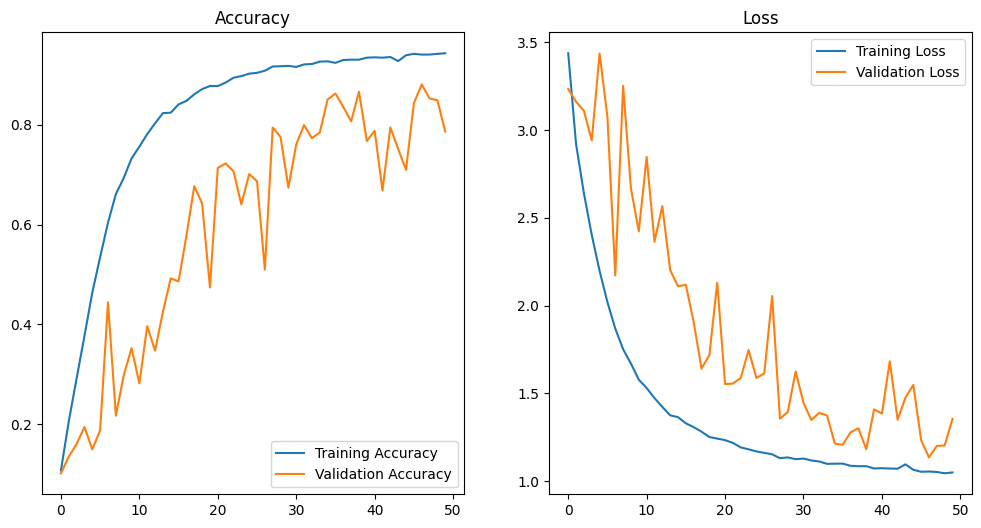

139/139 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step


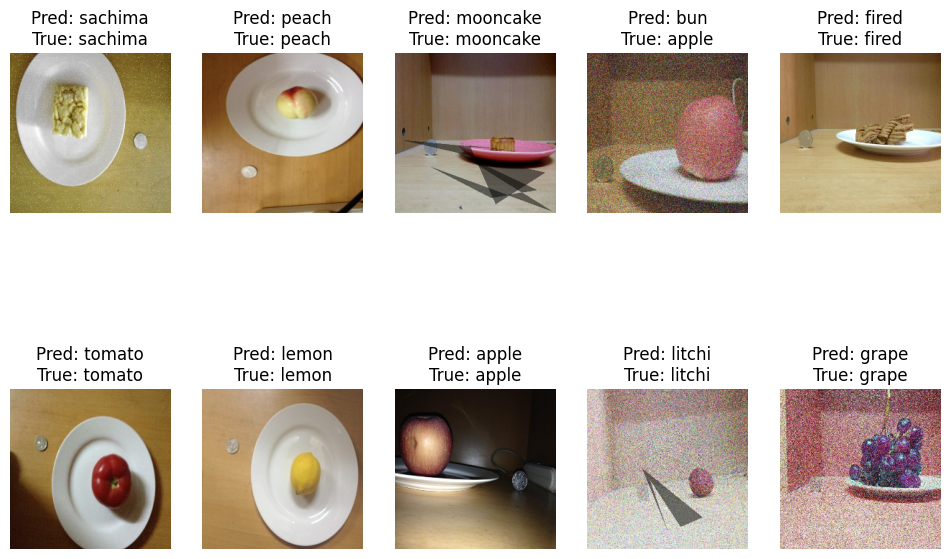

              precision    recall  f1-score   support

       apple       0.94      0.83      0.88       259
      banana       0.91      0.90      0.90       236
       bread       1.00      0.89      0.94       213
         bun       0.41      1.00      0.58       218
    doughnut       0.95      0.83      0.89       242
         egg       0.98      0.81      0.89       221
       fired       0.99      0.92      0.96       225
       grape       1.00      0.98      0.99       212
       lemon       0.98      0.90      0.94       230
      litchi       0.92      1.00      0.96       216
       mango       0.84      0.92      0.88       244
         mix       1.00      0.09      0.17        43
    mooncake       0.99      0.82      0.90       227
      orange       0.87      0.97      0.92       251
       peach       0.94      0.81      0.87       225
        pear       0.93      0.82      0.87       233
        plum       0.99      0.90      0.94       235
        qiwi       0.88    

In [7]:
# Tracer l'historique d'entraînement
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()

# Faire des prédictions sur l'ensemble de validation
predictions = model.predict(val_dataset)
predicted_classes = np.argmax(predictions, axis=1)

# Convertir les classes prédites en noms de classes
predicted_labels = label_encoder.inverse_transform(predicted_classes)

# Visualiser quelques prédictions
plt.figure(figsize=(12, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    idx = np.random.randint(len(val_paths))
    img = load_image(val_paths[idx])
    plt.imshow(img)
    plt.title(f"Pred: {predicted_labels[idx]}\nTrue: {label_encoder.inverse_transform([np.argmax(val_labels[idx])])[0]}")
    plt.axis('off')
plt.show()

# Évaluer les performances du modèle
from sklearn.metrics import classification_report

# Obtenir les vrais labels
true_labels = np.argmax(val_labels, axis=1)

# Afficher le rapport de classification
print(classification_report(true_labels, predicted_classes, target_names=label_encoder.classes_))

139/139 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step
Classification Report:
              precision    recall  f1-score   support

       apple       0.94      0.83      0.88       259
      banana       0.91      0.90      0.90       236
       bread       1.00      0.89      0.94       213
         bun       0.41      1.00      0.58       218
    doughnut       0.95      0.83      0.89       242
         egg       0.98      0.81      0.89       221
       fired       0.99      0.92      0.96       225
       grape       1.00      0.98      0.99       212
       lemon       0.98      0.90      0.94       230
      litchi       0.92      1.00      0.96       216
       mango       0.84      0.92      0.88       244
         mix       1.00      0.09      0.17        43
    mooncake       0.99      0.82      0.90       227
      orange       0.87      0.97      0.92       251
       peach       0.94      0.81      0.87       225
        pear       0.93      0.82      0.87       233
        plum    

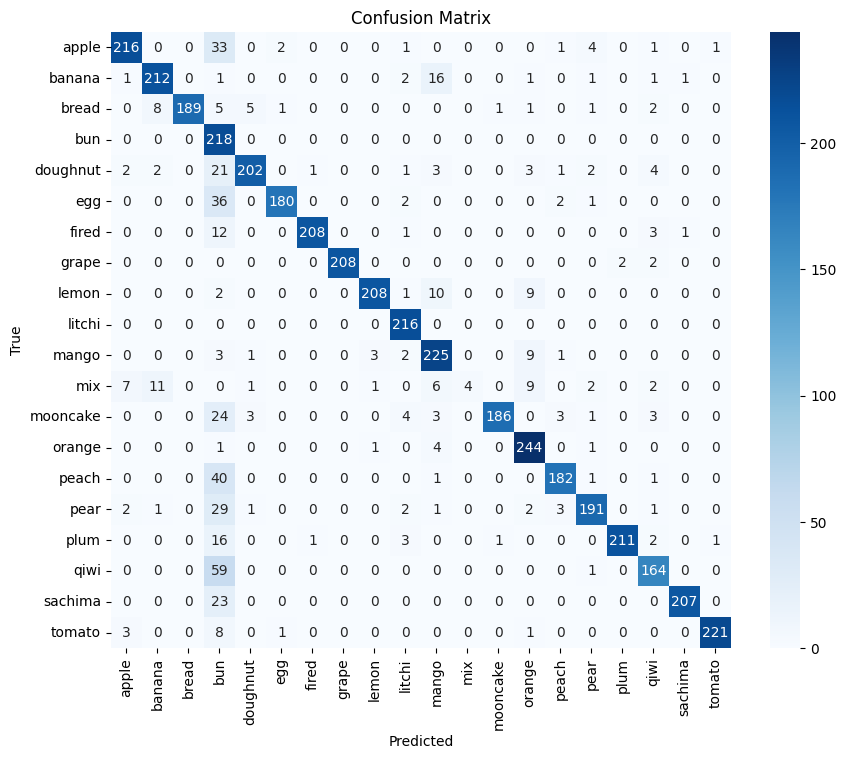

AUC-ROC Scores:
apple: 0.9945
banana: 0.9966
bread: 1.0000
bun: 0.9981
doughnut: 0.9907
egg: 0.9971
fired: 0.9989
grape: 0.9999
lemon: 0.9993
litchi: 1.0000
mango: 0.9950
mix: 0.9610
mooncake: 0.9987
orange: 0.9978
peach: 0.9924
pear: 0.9892
plum: 0.9986
qiwi: 0.9925
sachima: 0.9977
tomato: 0.9996


In [8]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Faire des prédictions sur l'ensemble de validation
y_pred = model.predict(val_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir les probabilités en classes prédites

# Obtenir les vrais labels
y_true = np.argmax(val_labels, axis=1)  # Convertir les labels one-hot en classes

# 1. Rapport de Classification
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

# 2. Matrice de Confusion
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 3. AUC-ROC (pour chaque classe)
# Calculer l'AUC-ROC pour chaque classe
auc_scores = {}
for i, class_name in enumerate(label_encoder.classes_):
    auc_scores[class_name] = roc_auc_score((y_true == i).astype(int), y_pred[:, i])

# Afficher les scores AUC-ROC
print("AUC-ROC Scores:")
for class_name, auc_score in auc_scores.items():
    print(f"{class_name}: {auc_score:.4f}")

# 4. Précision, Rappel et F1-Score (détaillé par classe)
# Le rapport de classification (classification_report) affiche déjà ces métriques.

# Sauvegarder le Modèle et le Label Encoder

In [9]:
# Sauvegarder l'ensemble du modèle
model.save('food_classification_model.keras')

# Sauvegarder le LabelEncoder
import joblib
joblib.dump(label_encoder, 'label_encoder.pkl')

print("Modèle et LabelEncoder sauvegardés avec succès.")

Modèle et LabelEncoder sauvegardés avec succès.
